In [1]:
import bisect
import datetime as dt
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

WESTERN_EUROPE = ['Andorra', 'Austria', 'Belgium', 'France', 'Ireland',
                  'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain',
                  'Switzerland', 'United Kingdom']
LAST_DAY = dt.datetime.utcnow().date() - dt.timedelta(days=1)
FIRST_DAY = LAST_DAY - dt.timedelta(days=30)

In [2]:
# Cases:
URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
FILENAME = 'data/time_series_covid19_confirmed_global.csv'

with urllib.request.urlopen(URL) as testfile, open(FILENAME, 'w') as f:
    f.write(testfile.read().decode())

pd_cases = pd.read_csv(FILENAME)
pd_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,110,120,170,174,237,273,281,299,349,367
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,197,212,223,243,259,277,304,333,361,377
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,454,511,584,716,847,986,1171,1251,1320,1423
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,308,334,370,376,390,428,439,466,501,525
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,5,7,7,7,8,8,8,10,14,16


In [3]:
# Recoveries:
URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
FILENAME = 'data/time_series_covid19_recovered_global.csv'

with urllib.request.urlopen(URL) as testfile, open(FILENAME, 'w') as f:
    f.write(testfile.read().decode())

pd_recs = pd.read_csv(FILENAME)
pd_recs.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2,2,2,5,5,10,10,10,15,18
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,33,44,52,67,76,89,99,104,116
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,31,31,37,46,61,61,62,90,90,90
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,10,10,10,10,16,21,26,31
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,1,1,1,1,2,2,2


In [4]:
# Deaths:
URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
FILENAME = 'data/time_series_covid19_deaths_global.csv'

with urllib.request.urlopen(URL) as testfile, open(FILENAME, 'w') as f:
    f.write(testfile.read().decode())

pd_deaths = pd.read_csv(FILENAME)
pd_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,4,4,4,4,4,6,6,7,7,11
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,10,10,11,15,15,16,17,20,20,21
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,29,31,35,44,58,86,105,130,152,173
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,3,6,8,12,14,15,16,17,18,21
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,2,2,2,2,2,2,2,2,2


In [5]:
cases, cases_wo_us, cases_we = [], [], []
recs, recs_wo_us, recs_we = [], [], []
deaths, deaths_wo_us, deaths_we = [], [], []

date_strs = sorted(filter(lambda d: d.endswith('/20'), set(pd_cases.columns) & set(pd_recs.columns) & set(pd_deaths.columns)), key=lambda d: (parts := d.split('/')) and (parts[0], int(parts[1])))
dates = [dt.datetime.strptime(ds, '%m/%d/%y').date() for ds in date_strs]

for c in date_strs:
    cases.append(pd_cases[c].sum())
    cases_wo_us.append(pd_cases[pd_cases['Country/Region'] != 'US'][c].sum())
    cases_we.append(pd_cases[pd_cases['Country/Region'].isin(WESTERN_EUROPE)][c].sum())
    
    recs.append(pd_recs[c].sum())
    recs_wo_us.append(pd_recs[pd_recs['Country/Region'] != 'US'][c].sum())
    recs_we.append(pd_recs[pd_recs['Country/Region'].isin(WESTERN_EUROPE)][c].sum())
    
    deaths.append(pd_deaths[c].sum())
    deaths_wo_us.append(pd_deaths[pd_deaths['Country/Region'] != 'US'][c].sum())
    deaths_we.append(pd_deaths[pd_deaths['Country/Region'].isin(WESTERN_EUROPE)][c].sum())

        
si = bisect.bisect_left(dates, FIRST_DAY)

def new_cases(cases):
    return [cases[i] - (cases[i-1] if i > 0 else 0) for i in range(len(cases))]

def growth_factor(cases):
    n_cases = new_cases(cases)
    return [(n_cases[i] / n_cases[i-1]) if i > 0 and n_cases[i-1] > 0 else 1. for i in range(len(n_cases))]

def active_cases(cases, recs, deaths):
    return [cases[i] - recs[i] - deaths[i] for i in range(len(cases))]

def recovery_rate(recs, deaths):
    return [recs[i] / (recs[i] + deaths[i]) for i in range(len(recs))]

In [6]:
data = pd.DataFrame(list(zip(dates, cases, new_cases(cases), growth_factor(cases), recs, deaths)),
                          columns=['Date', 'Total cases', 'New cases', 'Growth factor', 'Recoveries', 'Deaths'])
data.tail()

,Date,Total cases,New cases,Growth factor,Recoveries,Deaths
71,2020-04-02,1013157,80552,1.072340,210263,52983
72,2020-04-03,1095917,82760,1.027411,225796,58787
73,2020-04-04,1197405,101488,1.226293,246152,64606
74,2020-04-05,1272115,74710,0.736146,260012,69374
75,2020-04-06,1345048,72933,0.976215,276515,74565


<ipython-input-5-62a457619db4>:35: RuntimeWarning: invalid value encountered in long_scalars
  return [recs[i] / (recs[i] + deaths[i]) for i in range(len(recs))]


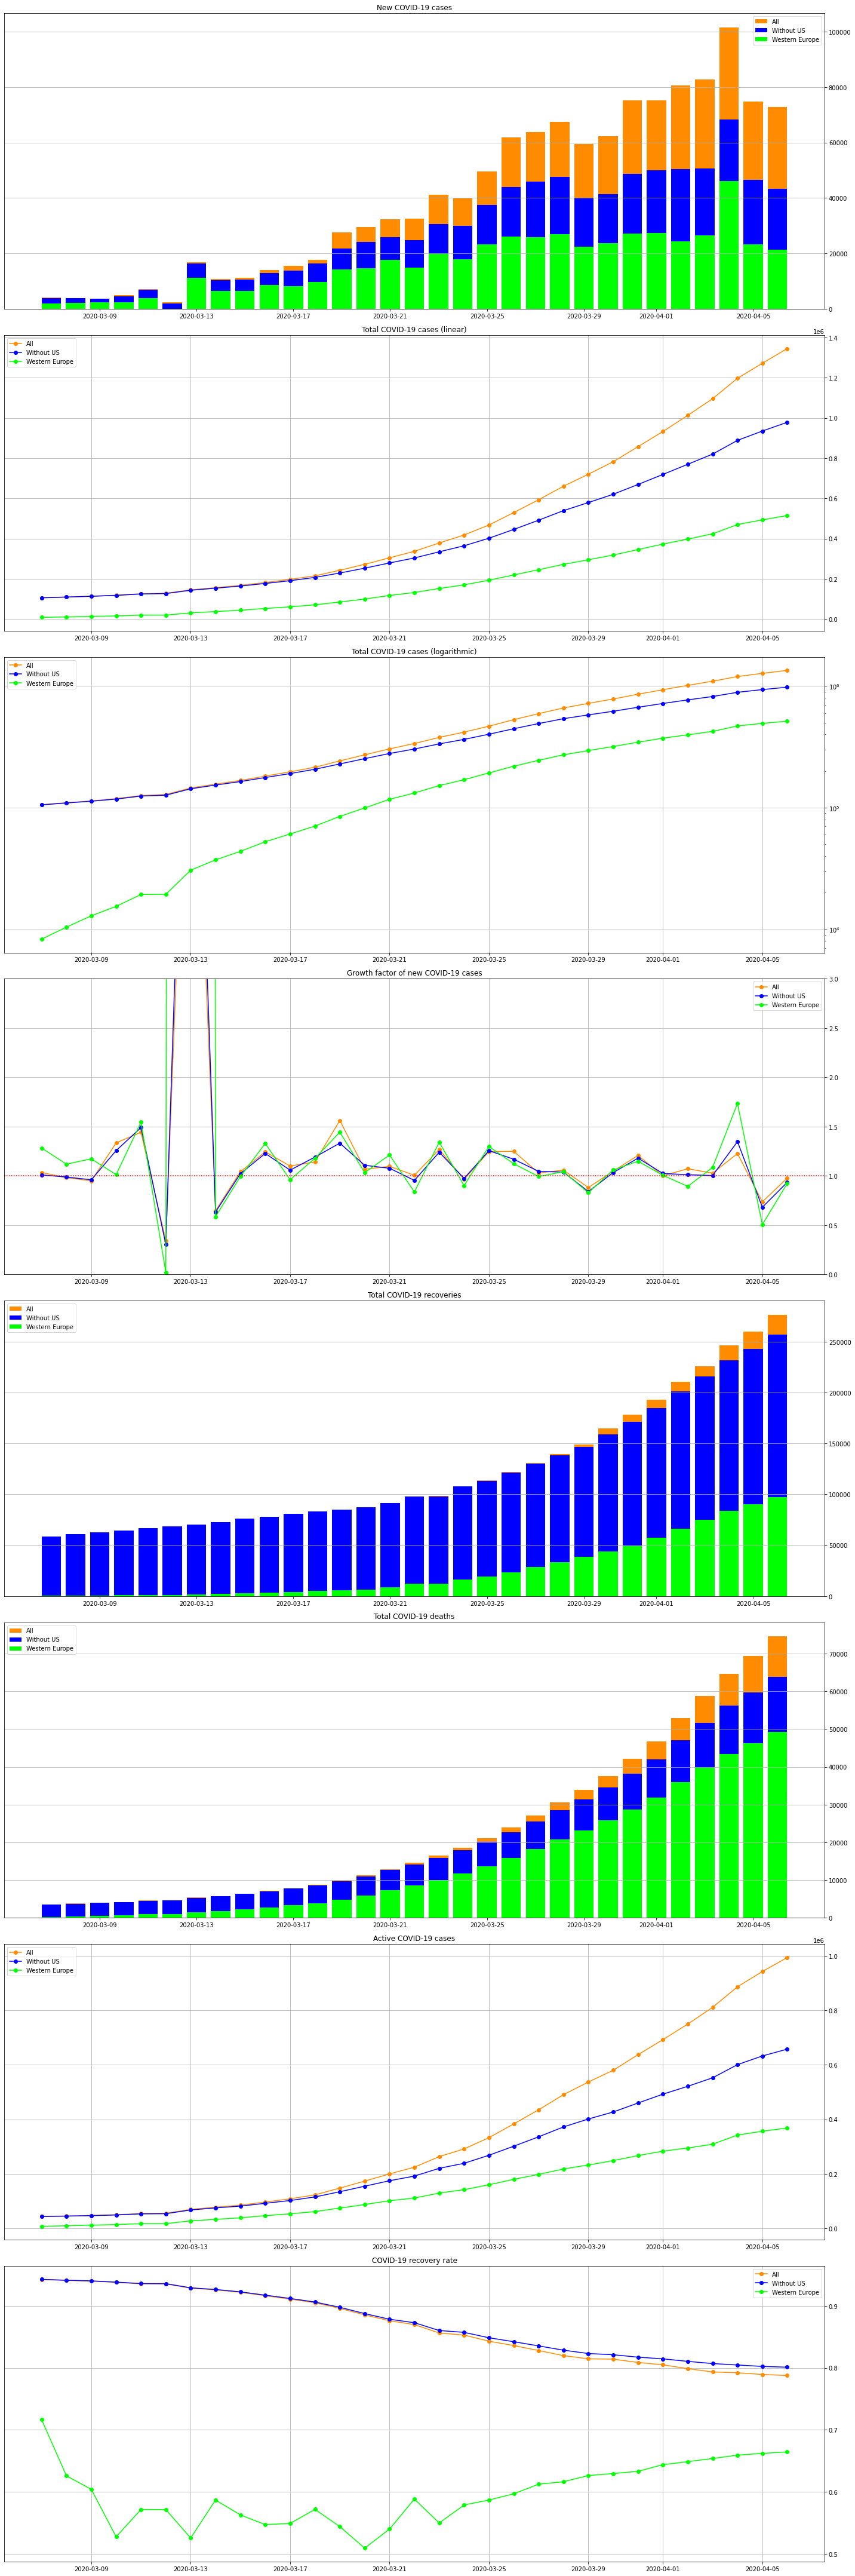

In [7]:
ALL_PARAMS = {'color': '#ff8c00', 'label': 'All'}
WO_US_PARAMS = {'color': '#0000ff', 'label': 'Without US'}
WE_PARAMS = {'color': '#00ff00', 'label': 'Western Europe'}

RESULT_FILE = 'graphs/COVID-19 plots.pdf'


fig = plt.figure(figsize=(20, 60))

nc_ax = plt.subplot(811)
nc_ax.bar(dates[si:], new_cases(cases)[si:], **ALL_PARAMS)
nc_ax.bar(dates[si:], new_cases(cases_wo_us)[si:], **WO_US_PARAMS)
nc_ax.bar(dates[si:], new_cases(cases_we)[si:], **WE_PARAMS)
nc_ax.yaxis.grid(True)
nc_ax.yaxis.tick_right()
nc_ax.legend()
nc_ax.set_title('New COVID-19 cases')

tc_ax = plt.subplot(812)
tc_ax.plot(dates[si:], cases[si:], marker='o', **ALL_PARAMS)
tc_ax.plot(dates[si:], cases_wo_us[si:], marker='o', **WO_US_PARAMS)
tc_ax.plot(dates[si:], cases_we[si:], marker='o', **WE_PARAMS)
tc_ax.grid(True)
tc_ax.yaxis.tick_right()
tc_ax.legend()
tc_ax.set_title('Total COVID-19 cases (linear)')

tc_log_ax = plt.subplot(813)
tc_log_ax.plot(dates[si:], cases[si:], marker='o', **ALL_PARAMS)
tc_log_ax.plot(dates[si:], cases_wo_us[si:], marker='o', **WO_US_PARAMS)
tc_log_ax.plot(dates[si:], cases_we[si:], marker='o', **WE_PARAMS)
tc_log_ax.set_yscale('log')
tc_log_ax.grid(True)
tc_log_ax.yaxis.tick_right()
tc_log_ax.legend()
tc_log_ax.set_title('Total COVID-19 cases (logarithmic)')

gf_ax = plt.subplot(814)
gf_ax.plot(dates[si:], growth_factor(cases)[si:], marker='o', **ALL_PARAMS)
gf_ax.plot(dates[si:], growth_factor(cases_wo_us)[si:], marker='o', **WO_US_PARAMS)
gf_ax.plot(dates[si:], growth_factor(cases_we)[si:], marker='o', **WE_PARAMS)
gf_ax.axhline(y=1.0, c='r', ls=':')
gf_ax.set_ylim(bottom=0, top=3)
gf_ax.grid(True)
gf_ax.yaxis.tick_right()
gf_ax.legend()
gf_ax.set_title('Growth factor of new COVID-19 cases')

tr_ax = plt.subplot(815)
tr_ax.bar(dates[si:], recs[si:], **ALL_PARAMS)
tr_ax.bar(dates[si:], recs_wo_us[si:], **WO_US_PARAMS)
tr_ax.bar(dates[si:], recs_we[si:], **WE_PARAMS)
tr_ax.yaxis.grid(True)
tr_ax.yaxis.tick_right()
tr_ax.legend()
tr_ax.set_title('Total COVID-19 recoveries')

td_ax = plt.subplot(816)
td_ax.bar(dates[si:], deaths[si:], **ALL_PARAMS)
td_ax.bar(dates[si:], deaths_wo_us[si:], **WO_US_PARAMS)
td_ax.bar(dates[si:], deaths_we[si:], **WE_PARAMS)
td_ax.yaxis.grid(True)
td_ax.yaxis.tick_right()
td_ax.legend()
td_ax.set_title('Total COVID-19 deaths')

tac_ax = plt.subplot(817)
tac_ax.plot(dates[si:], active_cases(cases, recs, deaths)[si:], marker='o', **ALL_PARAMS)
tac_ax.plot(dates[si:], active_cases(cases_wo_us, recs_wo_us, deaths_wo_us)[si:], marker='o', **WO_US_PARAMS)
tac_ax.plot(dates[si:], active_cases(cases_we, recs_we, deaths_we)[si:], marker='o', **WE_PARAMS)
tac_ax.grid(True)
tac_ax.yaxis.tick_right()
tac_ax.legend()
tac_ax.set_title('Active COVID-19 cases')

rr_ax = plt.subplot(818)
rr_ax.plot(dates[si:], recovery_rate(recs, deaths)[si:], marker='o', **ALL_PARAMS)
rr_ax.plot(dates[si:], recovery_rate(recs_wo_us, deaths_wo_us)[si:], marker='o', **WO_US_PARAMS)
rr_ax.plot(dates[si:], recovery_rate(recs_we, deaths_we)[si:], marker='o', **WE_PARAMS)
rr_ax.grid(True)
rr_ax.yaxis.tick_right()
rr_ax.legend()
rr_ax.set_title('COVID-19 recovery rate')

plt.tight_layout()
plt.savefig(RESULT_FILE)
plt.show()